In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [11]:
# Simulation parameters
grid_size = 100
dx = 0.1
dt = 0.1
time_steps = 1200
D_N = 0.001  # Reduced nutrient diffusion coefficient
alpha = 0.2  # Increased nutrient consumption rate
beta = 0.4  # Increased mycelium growth rate
gamma = 0.4  # Mycelium decay rate

# Hyphal tip dynamics parameters
D_T = 0.01  # Tip diffusion coefficient
v_max = 0.1  # Maximum velocity of hyphal tips toward nutrients
epsilon = 0.0001  # Small value to avoid division by zero


In [12]:
# Initialize nutrient and mycelium grids
N = np.ones((grid_size, grid_size)) * 0.00002  # Base nutrient concentration
M = np.zeros((grid_size, grid_size))  # Mycelium biomass
T = np.zeros((grid_size, grid_size))  # Hyphal tip density

# Add random nutrient islands (concentration = 0.8)
num_islands = 13  # Number of nutrient islands
island_radius = 5  # Radius of each island
island_concentration = 2.0  # Concentration in the nutrient islands

In [13]:
# Place islands of high nutrient concentration at random locations
for _ in range(num_islands):
    # Random center for the island
    center_x = np.random.randint(island_radius, grid_size - island_radius)
    center_y = np.random.randint(island_radius, grid_size - island_radius)
    
    # Set the nutrient concentration in a circular island
    for i in range(grid_size):
        for j in range(grid_size):
            distance = np.sqrt((i - center_x)**2 + (j - center_y)**2)
            if distance <= island_radius:
                N[i, j] = island_concentration

# Initial condition: small patch of mycelium and tips at the center
center = grid_size // 2
radius = 2
for i in range(grid_size):
    for j in range(grid_size):
        if (i - center) ** 2 + (j - center) ** 2 < radius ** 2:
            M[i, j] = 0.5  # Initial mycelium biomass
            T[i, j] = 1.5  # Initial hyphal tip density

In [14]:
# Function to update nutrient concentration using finite difference
def update_nutrient(N, M):
    N_new = np.copy(N)
    for i in range(1, grid_size-1):
        for j in range(1, grid_size-1):
            # Diffusion term
            laplacian_N = (N[i+1, j] + N[i-1, j] + N[i, j+1] + N[i, j-1] - 4 * N[i, j]) / dx**2
            # Nutrient update equation
            N_new[i, j] = N[i, j] + dt * (D_N * laplacian_N - alpha * M[i, j] * N[i, j])
    return N_new

In [15]:
# Function to update hyphal tips
def update_hyphal_tips(T, N):
    T_new = np.copy(T)
    for i in range(1, grid_size-1):
        for j in range(1, grid_size-1):
            # Calculate nutrient gradient
            grad_Nx = (N[i+1, j] - N[i-1, j]) / (2 * dx)
            grad_Ny = (N[i, j+1] - N[i, j-1]) / (2 * dx)
            
            # Compute tip velocity toward nutrients (steeper gradients = faster movement)
            v_x = v_max * grad_Nx / (epsilon + np.sqrt(grad_Nx**2 + grad_Ny**2))
            v_y = v_max * grad_Ny / (epsilon + np.sqrt(grad_Nx**2 + grad_Ny**2))
            
            # Update hyphal tip density with diffusion and advection
            laplacian_T = (T[i+1, j] + T[i-1, j] + T[i, j+1] + T[i, j-1] - 4 * T[i, j]) / dx**2
            advection_x = -v_x * (T[i+1, j] - T[i-1, j]) / (2 * dx)
            advection_y = -v_y * (T[i, j+1] - T[i, j-1]) / (2 * dx)
            
            # Update tip density
            T_new[i, j] = T[i, j] + dt * (D_T * laplacian_T + advection_x + advection_y)
    return T_new

In [16]:
# Function to update mycelium biomass with branching based on hyphal tip density
def update_mycelium_with_branching(N, M, T):
    M_new = np.copy(M)
    for i in range(grid_size):
        for j in range(grid_size):
            # Mycelium growth term with additional contribution from branching via tips
            growth = beta * M[i, j] * N[i, j]
            branching = 0.8 * T[i, j]  # New term from tip dynamics
            M_new[i, j] = M[i, j] + dt * (growth + branching - gamma * M[i, j])
    return M_new

In [17]:
path = os.getcwd()

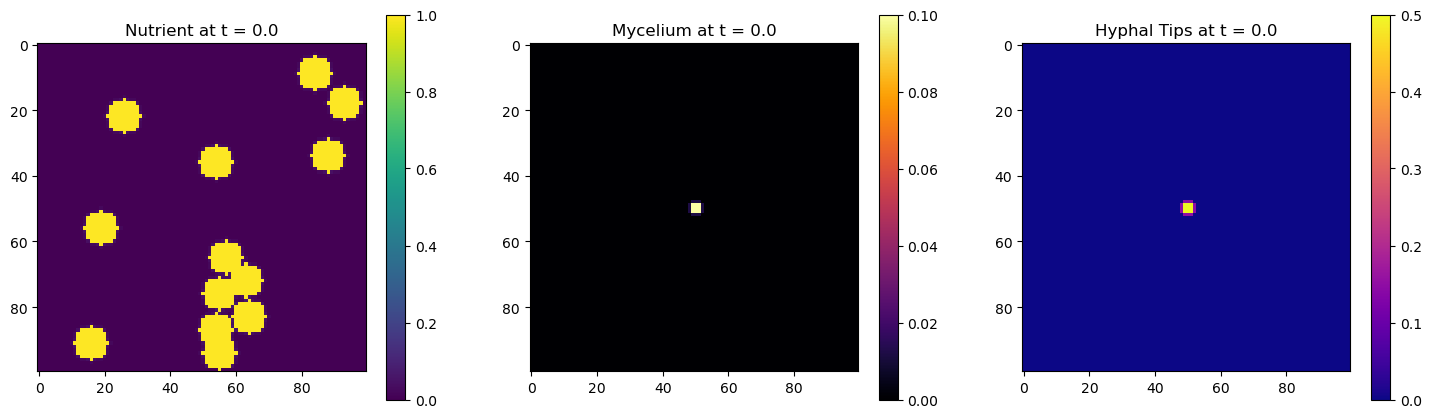

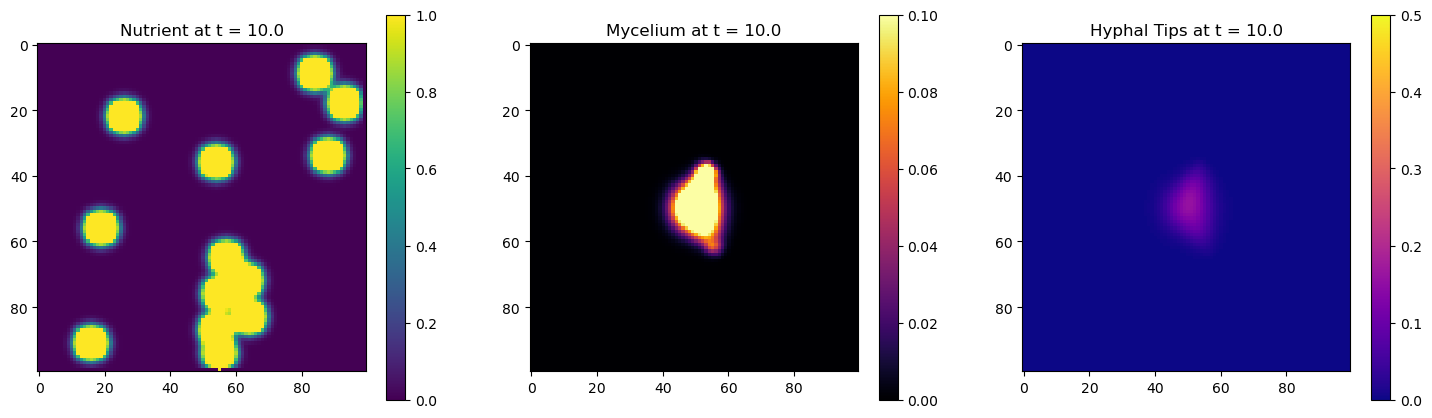

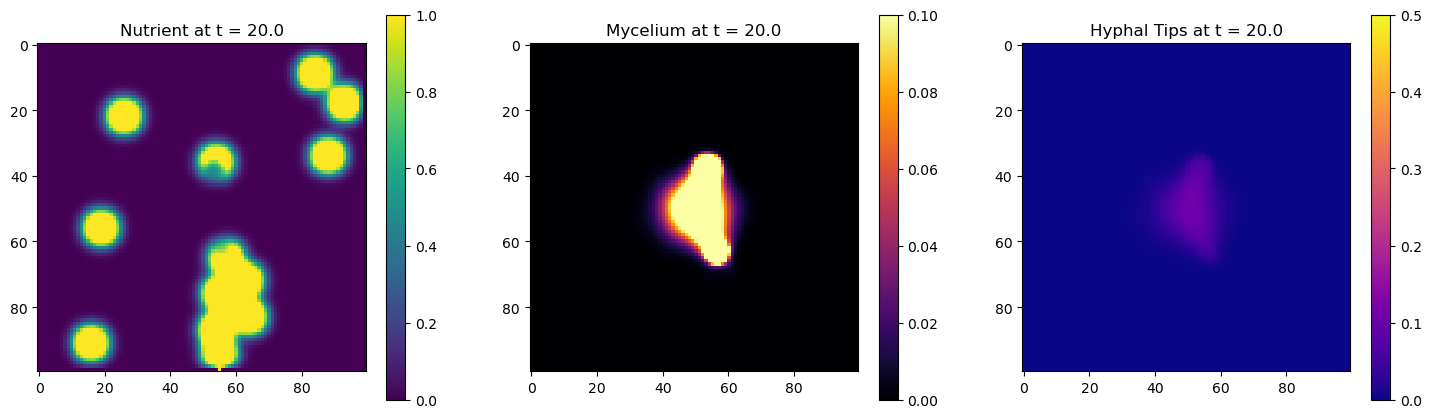

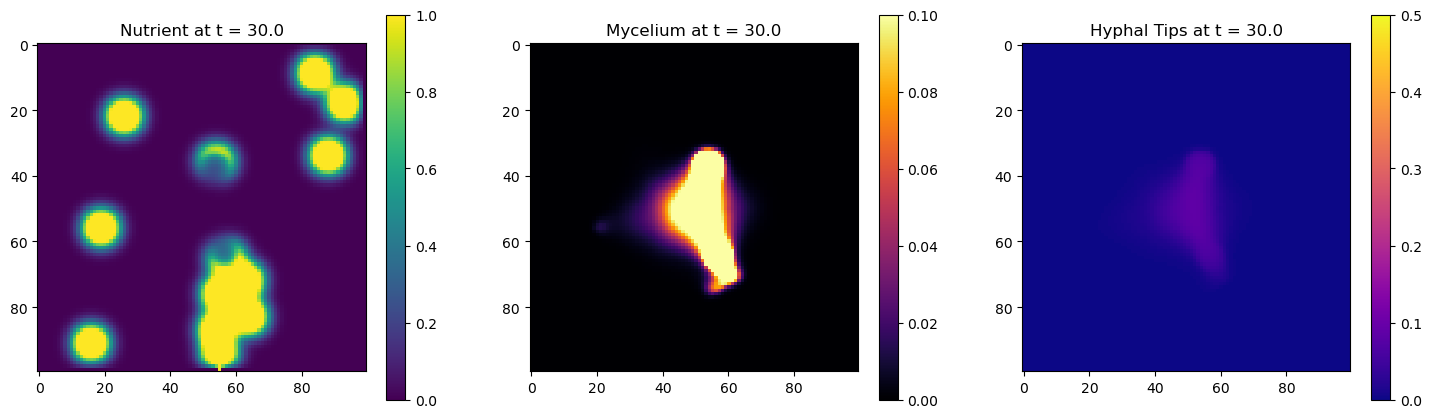

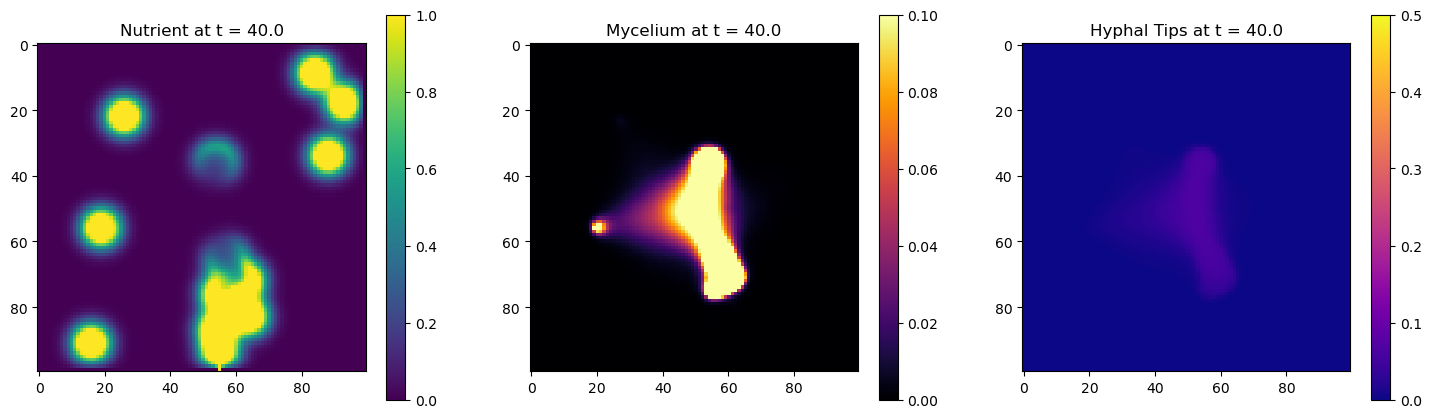

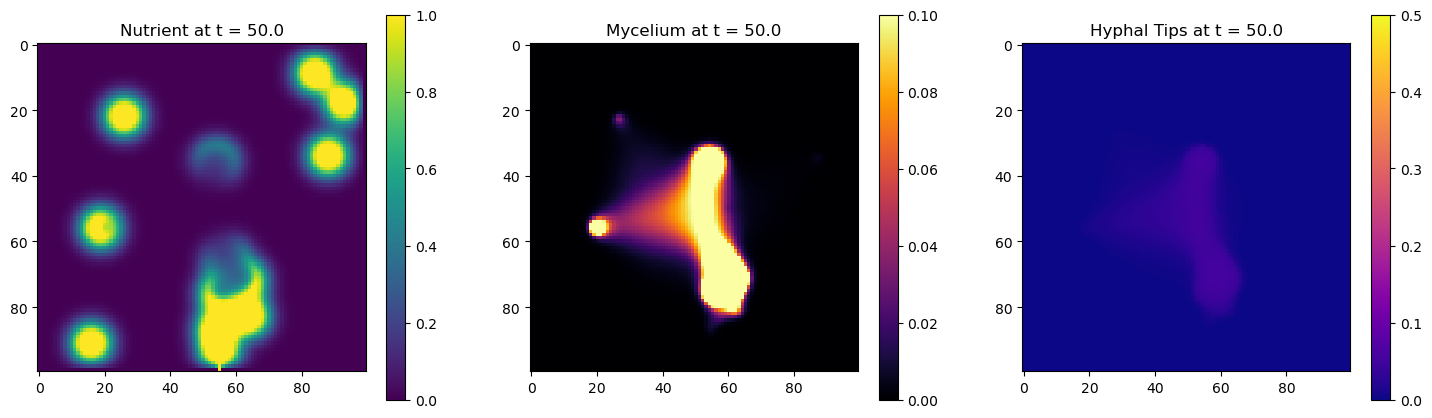

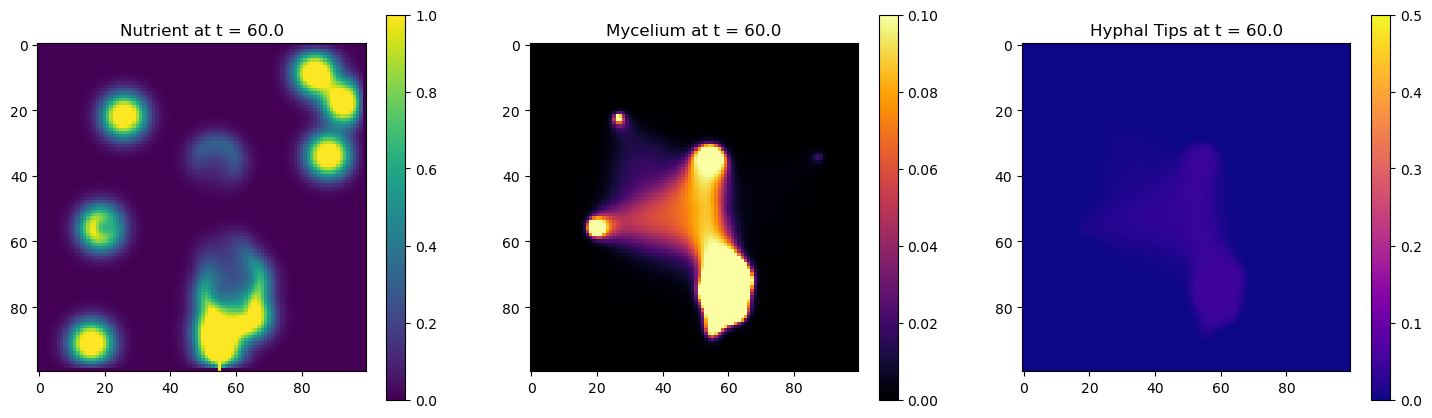

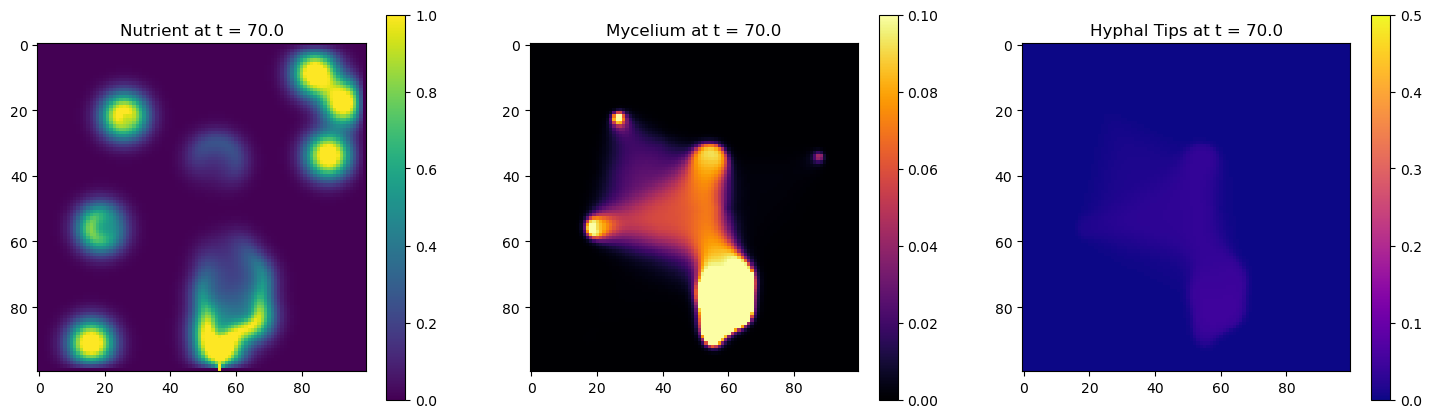

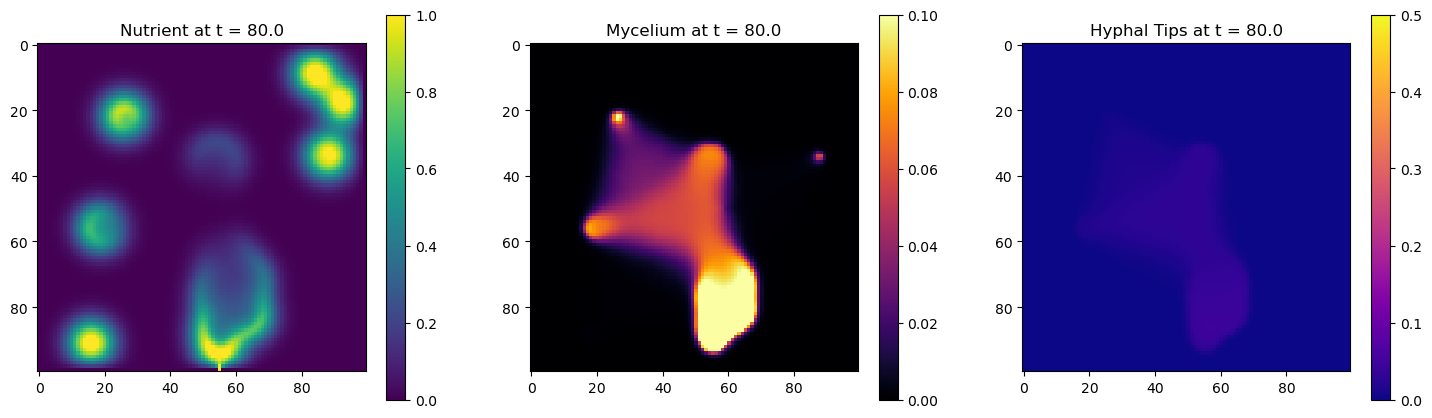

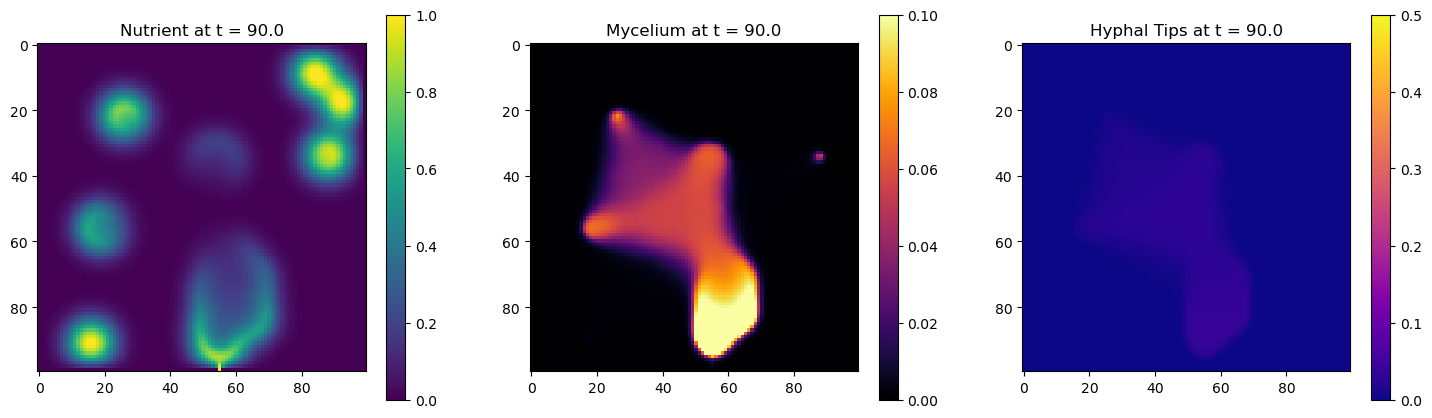

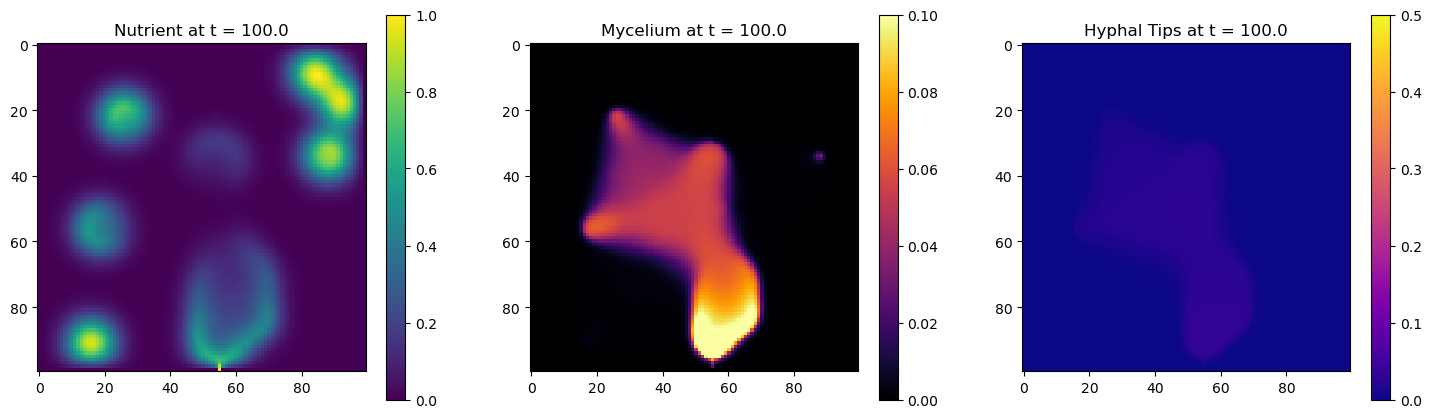

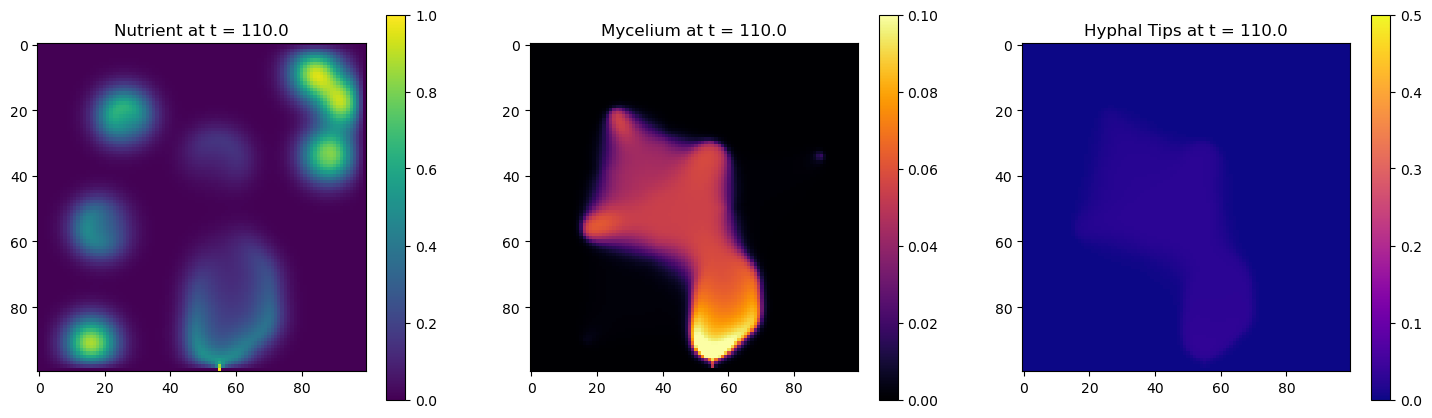

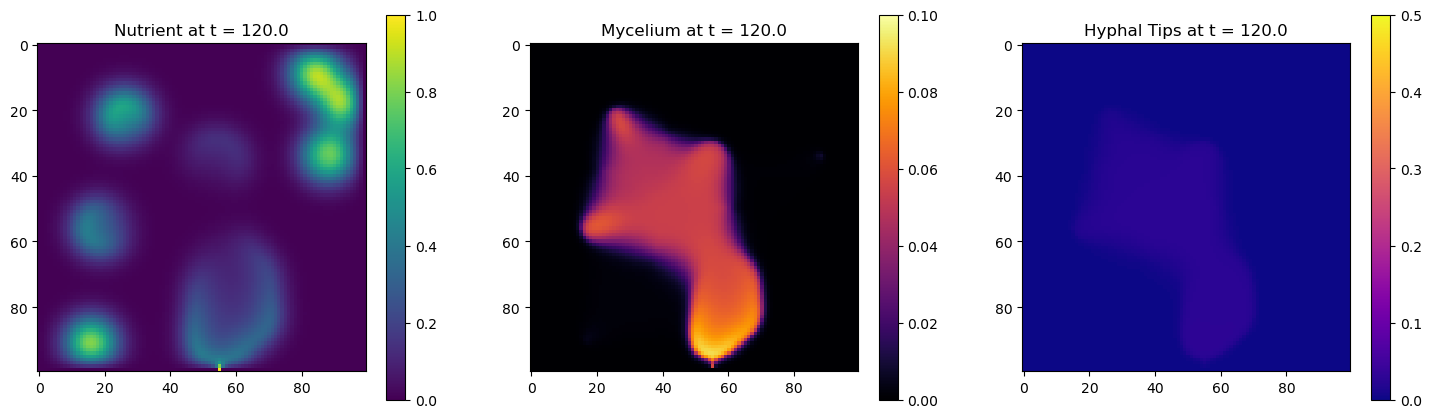

In [18]:
# Simulation loop
for t in range(time_steps+1):
    # Update nutrient concentration
    N = update_nutrient(N, M)
    
    # Update hyphal tips
    T = update_hyphal_tips(T, N)
    
    # Update mycelium with branching based on tips
    M = update_mycelium_with_branching(N, M, T)
    
        
        
        

    # Visualization every 100 time steps
    if t % 10 == 0:
        plt.figure(figsize=(18,5))
        plt.subplot(1, 3, 1)
        plt.imshow(N, cmap='viridis', vmin=0, vmax=1)
        plt.title(f'Nutrient at t = {t*dt}')
        plt.colorbar()
        
        #Save nutrient data

        nutrientDf = pd.DataFrame(N)
        nutrientDf.to_csv(f'{path}\\myceliumData\\nutrient_timestep{t}',index=False)

        plt.subplot(1, 3, 2)
        plt.imshow(M, cmap='inferno', vmin=0, vmax=0.1)
        plt.title(f'Mycelium at t = {t*dt}')
        plt.colorbar()
        
        #Save mycelium data
        myceliumDf = pd.DataFrame(M)
        myceliumDf.to_csv(f'{path}\\myceliumData\\mycelium_timestep{t}',index=False)

        plt.subplot(1, 3, 3)
        plt.imshow(T, cmap='plasma', vmin=0, vmax=0.5)
        plt.title(f'Hyphal Tips at t = {t*dt}')
        plt.colorbar()

        #plt.tight_layout()
        plt.show()